In [2]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

seed = 42
np.random.seed(seed=seed)

def train_generator(X_train, y_train, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_train), batch_size):
            x_batch = []
            y_batch = []            
            end = min(start + batch_size, len(X_train))
            train_batch = X_train[start:end]
            labels_batch = y_train[start:end]
            for i in range(len(train_batch)):
                data, _ = librosa.load(train_batch[i], sr = SR)
#                 data = random_data_shift(data, u = .2)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch

def valid_generator(X_val, y_val, batch_size, target_names, setting='stft'):
    from tensorflow.keras import utils
    while True:
        for start in range(0, len(X_val), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(X_val))
            test_batch = X_val[start:end]
            labels_batch = y_val[start:end]
            for i in range(len(test_batch)):
                data, _ = librosa.load(test_batch[i], sr = SR)
                # Expand dimensions
                data = np.expand_dims(data, axis = -1)
                if using_conv2d:
                    data = np.expand_dims(data, axis = -1)
                x_batch.append(data)
                y_batch.append(labels_batch[i])
            x_batch = np.array(x_batch, np.float32)
            y_batch = np.array(y_batch, np.float32)
            yield x_batch, y_batch
            
splitting = 'custom'
data_setting = 'raw'
model_setting = 'conv1d'

### Splitting mosquito data same way it was split to train

In [3]:
d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

Species: all.
Read 279566 filenames in 27.20 seconds.
Species: Ae. aegypti.
Read 85553 filenames in 2.68 seconds.
['20170208', '20170210', '20161212', '20161213', '20170206', '20170207', '20170209', '20170211', '20170212', '20170213']
82989 train filenames, 2564 test filenames
Species: Ae. albopictus.
Read 20231 filenames in 2.88 seconds.
['20170102', '20170103', '20170227', '20170228', '20170301']
17440 train filenames, 2791 test filenames
Species: An. arabiensis.
Read 19297 filenames in 2.75 seconds.
['20170130', '20170131', '20170201', '20170202', '20170203', '20170204', '20170205', '20170314', '20170315', '20170317', '20170206', '20170313', '20170316', '20170318', '20170319', '20170320']
12897 train filenames, 2831 test filenames
Species: An. gambiae.
Read 49471 filenames in 2.84 seconds.
['20170116', '20170117', '20170118', '20170119', '20170120', '20170121', '20170122', '20170123', '20170109', '20170110']
45471 train filenames, 4000 test filenames
Species: C. quinquefasciatus.
Re

{'Ae. aegypti': 0,
 'Ae. albopictus': 1,
 'An. arabiensis': 2,
 'An. gambiae': 3,
 'C. pipiens': 4,
 'C. quinquefasciatus': 5}

### Loading MosquitoNet and removing its last 2 layers

In [4]:
# Defining model parameters
merged = True
if merged:
    # Merging the mosquito genuses together
    y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
    print(pd.Series(y_train).value_counts())
else:
    modelname = f'TL_{splitting}_{data_setting}_{model_setting}_weights'
using_conv2d = False
traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# NOT LOADING MODELS
model.load_weights(TEMP_DATADIR+modelname+'.h5')
model.summary()

# cut_mosquito_model is the model without its last dropout and softmax
cut_mosquito_model = Model(model.inputs, model.layers[-3].output)

0    80340
2    55920
1    46692
dtype: int64
############ INPUT SHAPE:(5000, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4998, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4996, 16)          784       
_________________________________________________________________
batch_normalization (BatchNo (None, 4996, 16)          64        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4994, 32)          1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4992, 32)          3104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 4992, 32)          128       
_________________________________________

## Reading Flies data and splitting into Train/Val/Test

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
import seaborn as sb
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from sklearn.utils import class_weight
import deepdish as dd
from wavhandler import *

In [6]:
dconf = Dataset('Pcfruit_sensor49')
dconf.read(loadmat=False);
dconf.get_sensor_features(temp_humd=False)
sub = dconf.df_features

mel_test_dates = ['20191216','20191217','20191220','20191221','20191222','20191223',
                 '20191224','20191225','20191226','20191227','20191228','20191229',
                 '20191230','20191231','20200101','20200102','20200103','20200104',
                 '20200105','20200106','20200107','20200108','20200109','20200110',
                 '20200111','20200112','20200113','20200114','20200115','20200116',
                 '20200117','20200118','20200119']
mel_val_dates = [['20200131','20200201'],['20200307'],['20200313','20200314','20200315','20200316']]
suz_test_dates = ['20200207', '20200208']
suz_val_dates = [['20200209'],['20200214'],['20200219']]

Species: all.
Read 10264 filenames in 0.13 seconds.


,filenames,wavnames,date,datestr,date_day,date_hour,gain,y
8294,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,F200207_170851_000_G_050_T_27.3_H_41.8,2020-02-07 17:08:51,20200207,7,17,050,D. suzukii
8295,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,F200207_170938_001_G_050_T_27.3_H_41.4,2020-02-07 17:09:38,20200207,7,17,050,D. suzukii
8296,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,F200207_171506_002_G_050_T_28.0_H_43.8,2020-02-07 17:15:06,20200207,7,17,050,D. suzukii
8297,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,F200207_171605_003_G_050_T_28.0_H_44.3,2020-02-07 17:16:05,20200207,7,17,050,D. suzukii
8298,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,F200207_171835_004_G_050_T_28.7_H_44.3,2020-02-07 17:18:35,20200207,7,17,050,D. suzukii


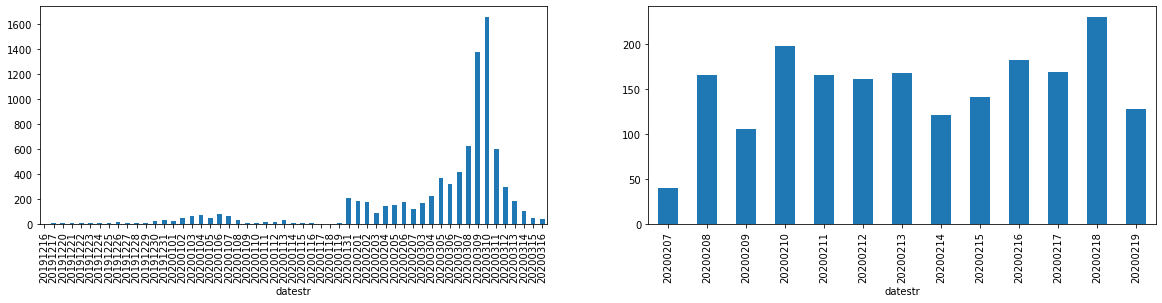

In [7]:
sub['y'] = dconf.df_features.filenames.apply(lambda x: x.split('/')[dconf.class_path_idx])
df_suz = sub[sub['y'] == 'D. suzukii']
df_mel = sub[sub['y'] == 'D. melanogaster']

plt.figure(figsize=(20,4))
plt.subplot(121); df_mel.groupby('datestr')['filenames'].count().plot(kind="bar")
plt.subplot(122); df_suz.groupby('datestr')['filenames'].count().plot(kind="bar")

df_suz.head()

In [8]:
mel_test = df_mel[df_mel.datestr.isin(mel_test_dates)][['filenames','y']]
suz_test = df_suz[df_suz.datestr.isin(suz_test_dates)][['filenames','y']]
suz_test.sample(5)

,filenames,y
8336,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. suzukii
8303,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. suzukii
9520,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. suzukii
10065,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. suzukii
9411,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. suzukii


In [9]:
# For the test set we made 1 dataframe for each insect species,
# but for the validation set we have a list of 3 dataframes for each species
# since we select three validation sets.
mel_val, suz_val = [],[]
for i in range(3):
    suz_val.append(df_suz[df_suz.datestr.isin(suz_val_dates[i])][['filenames','y']])
    mel_val.append(df_mel[df_mel.datestr.isin(mel_val_dates[i])][['filenames','y']])
mel_val[0].sample(5)

,filenames,y
1217,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
1204,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
609,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
694,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
777,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster


In [10]:
lenc = LabelEncoder()
lenc.fit(dconf.y)

test = pd.concat([mel_test, suz_test])
Xf_test = test.filenames.tolist()
yf_test = lenc.transform(test.y).tolist()
# Trainval contains all data for training and validation sets [it excludes test set]
trainval = sub[~sub.filenames.isin(Xf_test)][['filenames','y']]
trainval.sample(5)

,filenames,y
3359,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
5173,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
7805,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster
9305,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. suzukii
3797,/media/yannis/HGST_4TB/Ubudirs/data/insects/Pc...,D. melanogaster


# Function to create model, extract features and train

In [11]:
def create_top_model(cut_mosquito_model):
    ### Creating a shallow model to put on top of Mosquito model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=cut_mosquito_model.output_shape[1:]))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))
    top_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return top_model

def extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val):
    ### Passing fly data through the cut Mosquito model to get output
    ##### This output will be used to train the shallow model for few epochs

    Xf_xtracted_train = cut_mosquito_model.predict_generator(valid_generator(Xf_train, 
                                                    yf_train, 
                                                    batch_size=128, 
                                                    setting='raw', 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_train)) / float(128))))

    Xf_xtracted_val = cut_mosquito_model.predict_generator(valid_generator(Xf_val, 
                                                    yf_val, 
                                                    batch_size=128, 
                                                    setting='raw', 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_val)) / float(128))))    
    return Xf_xtracted_train, Xf_xtracted_val

def train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
                cut_mosquito_model, top_model, frozen_layers=0):
    
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(yf_train), y=yf_train)
    
    ### Training Shallow model for a few epochs
    traincf_flies = TrainConfiguration(dataset=dconf, setting='raw', monitor='val_accuracy', 
                                       model_name=f'top_model_flies', batch_size=32, epochs=5)
    top_model.fit(Xf_xtracted_train, yf_train, 
                  validation_data=(Xf_xtracted_val,yf_val),
                  batch_size=traincf_flies.batch_size, 
                  epochs=traincf_flies.epochs, 
                  callbacks=traincf_flies.callbacks_list,
                 class_weight=class_weights,
                 verbose=0);
    ### Freezing first few layers of MosquitoNet
    if frozen_layers > 0:
        for lay in cut_mosquito_model.layers[:frozen_layers]:
            lay.trainable = False
    ### Adding shallow model on top of the cut Mosquito model
    inputA = Input(cut_mosquito_model.input_shape[1:])
    outputA = cut_mosquito_model(inputA)
    outputB = top_model(outputA)
    modelC = Model(inputA, outputB)
    modelC.compile(loss='mse',
                  optimizer='adam',#optimizers.SGD(lr=1e-3, momentum=0.9),
                  metrics=['accuracy'])
    ### Training MosquitoNet+Shallow
    traincf_flies = TrainConfiguration(dataset=dconf, setting='raw', monitor='val_accuracy', es_patience=4, rlr_patience=4, model_name=f'whole_model_flies', batch_size=32)
    h = modelC.fit_generator(train_generator(Xf_train, yf_train, 
                                        batch_size=traincf_flies.batch_size,
                                        target_names=traincf_flies.target_names,
                                        setting=traincf_flies.setting),
                        steps_per_epoch = int(math.ceil(float(len(Xf_train)) / float(traincf_flies.batch_size))),
                        epochs = traincf_flies.epochs,
                        validation_data = valid_generator(Xf_val, yf_val,
                                                            batch_size=traincf_flies.batch_size,
                                                            target_names=traincf_flies.target_names,
                                                            setting=traincf_flies.setting),
                        validation_steps=int(math.ceil(float(len(Xf_test))/float(traincf_flies.batch_size))),
                        callbacks=traincf_flies.callbacks_list, 
                        class_weight=class_weights, 
                        verbose=0);

    yf_pred = modelC.predict_generator(valid_generator(Xf_test, 
                                                    yf_test, 
                                                    batch_size=128, 
                                                    setting='raw', 
                                                    target_names=['suz','mel']),
                                                steps = int(math.ceil(float(len(Xf_test)) / float(128))))
    return yf_pred, h, modelC


In [12]:
def myjob(trainval, mel_val, suz_val, Xf_test, yf_test, trial=0, frozen_layers=0, smpl=100, valset=0):
    savepath = f'../temp_data/merged{merged}_nr{frozen_layers}_samples{smpl}_val{valset}_trial{trial}.csv'
    print(savepath)
    if os.path.isfile(savepath):
        print("ALREADY EXISTS")
        return

    print(f'\n\n###########\nNOW USING {smpl} SAMPLES in {valset} VALIDATION FOLD\n##############')
    smpl_results = {}

    valfold_mel = trainval[trainval.filenames.isin(mel_val[valset].filenames)]
    valfold_suz = trainval[trainval.filenames.isin(suz_val[valset].filenames)]
    validation = pd.concat([valfold_mel, valfold_suz])
    Xf_val = validation.filenames.tolist()
    yf_val = lenc.transform(validation.y)

    train = trainval[~trainval.filenames.isin(validation.filenames)]
    train_smpl = shuffle(train.sample(smpl, random_state=seed), random_state=seed)
    Xf_train, yf_train = train_smpl.filenames.tolist(), lenc.transform(train_smpl.y)

    print(f"Train: \n{pd.Series(yf_train).value_counts()}")
    print(f"Val: \n{pd.Series(yf_val).value_counts()}")
    print(f"Test: \n{pd.Series(yf_test).value_counts()}")    

    # cut_mosquito_model = Model(model.inputs, model.layers[-3].output)
    top_model = create_top_model(cut_mosquito_model)
    Xf_xtracted_train, Xf_xtracted_val = extract_features_mosquitonet(Xf_train, yf_train, Xf_val, yf_val)
    yf_pred, h, modelC = train_model(Xf_train, yf_train, Xf_val, yf_val, Xf_xtracted_train, Xf_xtracted_val, 
                                     cut_mosquito_model, top_model, frozen_layers=frozen_layers)

    lb = LabelBinarizer()
    thr = 0.5
    yf_pred_thresholded = lb.fit_transform(yf_pred > thr)
    cm = confusion_matrix(yf_test, yf_pred_thresholded).astype(float)
    smpl_results['yf_test'] = yf_test
    smpl_results['yf_pred'] = yf_pred
    smpl_results['yf_pred_thresholded'] = yf_pred_thresholded
    smpl_results['nr_samples'] = smpl
    smpl_results['trial'] = trial
    smpl_results['frozen_layers'] = frozen_layers
    smpl_results['accuracy_score'] = accuracy_score(yf_test, yf_pred_thresholded)
    smpl_results['balanced_accuracy_score'] = balanced_accuracy_score(yf_test, yf_pred_thresholded)
    smpl_results['cm'] = cm
    #     smpl_results['classification_report'] = classification_report(yf_test, yf_pred_thresholded)
    smpl_results['history'] = h.history

    dd.io.save(savepath, smpl_results)
    print('Done.')

In [13]:
samples = [100, 250, 500, 1000, 2000, 4000, 6000, 8000]
froz_layerlist = [0, 5, 15, 19]
trials = [0,1,2,3,4,5,6,7,8,9]

for trial in trials:
    for frozen_layers in froz_layerlist:
        for valset in range(3):
            for smpl in samples:
                myjob(trainval, mel_val, suz_val, Xf_test, yf_test, trial=trial, frozen_layers=frozen_layers, smpl=smpl, valset=valset)

../temp_data/mergedTrue_nr0_samples100_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples250_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples500_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples1000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples2000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples4000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples6000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples8000_val0_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples100_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples250_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples500_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples1000_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples2000_val1_trial0.csv
ALREADY EXISTS
../temp_data/mergedTrue_nr0_samples4000_val1_trial0.csv
ALREADY EXISTS
../temp_data

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val0_trial7.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.49899, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.49899 to 0.58621, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.58621 to 0.66126, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.66126 to 0.76876, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.76876 to 0.86815, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val0_trial7.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.70385, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.70385 to 0.80122, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.80122 to 0.84179, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.84179 to 0.88641, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.88641 to 0.89858, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val0_trial7.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.56795, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.56795 to 0.65517, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.65517 to 0.72617, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.72617 to 0.79310, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79310 to 0.82961, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val0_trial7.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.60243, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.60243 to 0.64503, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.64503 to 0.70183, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.70183 to 0.76268, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.76268 to 0.80527, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val0_trial7.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.83773, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.83773 to 0.90264, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90264 to 0.91481, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.91481

Epoch 00005: val_accuracy did not improve from 0.91481
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89396, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val0_trial7.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91278, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91278 to 0.92292, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92292

Epoch 00004: val_accuracy did not improve from 0.92292

Epoch 00005: val_accuracy did not improve from 0.92292

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88940, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val0_trial7.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89858, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89858 to 0.91075, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.91075

Epoch 00004: val_accuracy did not improve from 0.91075

Epoch 00005: val_accuracy improved from 0.91075 to 0.91481, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88255, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val0_trial7.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94320, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94320

Epoch 00003: val_accuracy did not improve from 0.94320

Epoch 00004: val_accuracy did not improve from 0.94320

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94320
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89510, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89510 to 0.91026, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val1_trial7.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73783, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.73783 to 0.88202, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.88202 to 0.92509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92509 to 0.93820, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93820
  ...
    to  
  ['...']
  ...
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val1_trial7.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.71161, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.71161 to 0.77341, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77341 to 0.78464, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.78464 to 0.79213, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79213 to 0.80524, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val1_trial7.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88577, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88577 to 0.92884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92884

Epoch 00004: val_accuracy did not improve from 0.92884

Epoch 00005: val_accuracy did not improve from 0.92884

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94018, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbea

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val1_trial7.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.84457, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.84457 to 0.87640, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.87640 to 0.88577, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88577 to 0.90449, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90449 to 0.91011, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val1_trial7.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92509

Epoch 00003: val_accuracy improved from 0.92509 to 0.92884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92884 to 0.93071, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93071 to 0.94382, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val1_trial7.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89700, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89700 to 0.93258, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93258 to 0.94195, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94195 to 0.95880, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.95880 to 0.96067, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val1_trial7.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93446 to 0.95506, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.95506 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.96816 to 0.97004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.97004
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val1_trial7.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.95318, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.95318 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96816

Epoch 00004: val_accuracy did not improve from 0.96816

Epoch 00005: val_accuracy did not improve from 0.96816

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98081, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val2_trial7.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.54959, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.54959 to 0.63843, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.63843 to 0.72107, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.72107 to 0.76653, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.76653 to 0.80579, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val2_trial7.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.70661, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.70661 to 0.90702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90702 to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.91116

Epoch 00005: val_accuracy did not improve from 0.91116
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94009, saving model to /media/yannis/HGST

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val2_trial7.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.70041, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.70041 to 0.73967, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.73967 to 0.75207, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.75207 to 0.78512, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.78512 to 0.81818, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val2_trial7.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.85537, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.85537 to 0.89463, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.89463 to 0.90083, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.90083 to 0.91529, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.91529 to 0.91736, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val2_trial7.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92149

Epoch 00003: val_accuracy did not improve from 0.92149

Epoch 00004: val_accuracy improved from 0.92149 to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92769 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95507, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val2_trial7.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91529, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91529 to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92769 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93595 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93802 to 0.94008, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val2_trial7.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93802 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94008

Epoch 00004: val_accuracy improved from 0.94008 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94421
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val2_trial7.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93182, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93182 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94215

Epoch 00004: val_accuracy improved from 0.94215 to 0.94628, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94628
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.21501, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.21501 to 0.23327, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.23327 to 0.31237, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.31237 to 0.43408, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.43408 to 0.53753, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.76471, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.76471 to 0.85801, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85801 to 0.88032, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88032 to 0.90872, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90872 to 0.92089, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96552, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.96552

Epoch 00003: val_accuracy did not improve from 0.96552

Epoch 00004: val_accuracy did not improve from 0.96552

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.96552
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.92930, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92930

Epoch 0000

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.76471, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.76471 to 0.90264, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.90264

Epoch 00004: val_accuracy improved from 0.90264 to 0.90467, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90467 to 0.91075, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.86207, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.86207 to 0.90669, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90669 to 0.91481, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91481 to 0.91684, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.91684 to 0.92292, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91684, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91684 to 0.92901, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92901

Epoch 00004: val_accuracy did not improve from 0.92901

Epoch 00005: val_accuracy did not improve from 0.92901

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89054, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wing

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91278, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.91278

Epoch 00003: val_accuracy improved from 0.91278 to 0.91886, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.91886

Epoch 00005: val_accuracy did not improve from 0.91886
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88597, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improve

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91481, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.91481

Epoch 00003: val_accuracy did not improve from 0.91481

Epoch 00004: val_accuracy did not improve from 0.91481

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.91481
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90422, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90422 to 0.90909, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.52622, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.52622 to 0.65730, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.65730 to 0.75094, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.75094 to 0.80524, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.80524 to 0.86330, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.54869, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.54869 to 0.83146, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.83146 to 0.87453, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.87453 to 0.88951, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.88951
  ...
    to  
  ['...']
  ...
 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.84457, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.84457 to 0.91948, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91948 to 0.92509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.92509

Epoch 00005: val_accuracy improved from 0.92509 to 0.93258, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88202, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.88202

Epoch 00003: val_accuracy improved from 0.88202 to 0.88764, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88764 to 0.90075, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90075 to 0.91573, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87640, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87640 to 0.90262, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90262 to 0.93258, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.93258

Epoch 00005: val_accuracy improved from 0.93258 to 0.94007, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90637, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90637 to 0.94007, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94007 to 0.95318, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.95318 to 0.95693, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.95693 to 0.96067, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91948, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91948 to 0.94944, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94944 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.96629

Epoch 00005: val_accuracy did not improve from 0.96629
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97856, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93446 to 0.95693, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.95693 to 0.97191, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.97191

Epoch 00005: val_accuracy did not improve from 0.97191
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.98081, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.58264, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.58264 to 0.65909, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.65909 to 0.73554, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.73554 to 0.77479, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.77479 to 0.80579, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.76653, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.76653 to 0.79339, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.79339 to 0.80785, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.80785 to 0.83058, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.83058 to 0.85124, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.86157, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.86157 to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92769

Epoch 00004: val_accuracy did not improve from 0.92769

Epoch 00005: val_accuracy did not improve from 0.92769

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.93548, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90909, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.90909

Epoch 00003: val_accuracy did not improve from 0.90909

Epoch 00004: val_accuracy improved from 0.90909 to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.92149
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94931, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not i

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89669, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89669 to 0.91529, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91529 to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92149 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93388
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89256, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89256 to 0.92975, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92975 to 0.93182, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93182 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93595 to 0.93802, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92562 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94008 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94215 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94421
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92562 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93802 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.94215

Epoch 00005: val_accuracy improved from 0.94215 to 0.94628, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.74442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.74442 to 0.77688, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77688 to 0.78702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.78702

Epoch 00005: val_accuracy improved from 0.78702 to 0.78905, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
   

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.85396, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.85396 to 0.88641, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.88641 to 0.91684, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91684 to 0.93103, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93103
  ...
    to  
  ['...']
  ...
 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.39148, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.39148 to 0.75862, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.75862 to 0.86410, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.86410 to 0.89655, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.89655 to 0.90669, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82556, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82556 to 0.86207, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.86207 to 0.88032, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88032 to 0.89858, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.89858
  ...
    to  
  ['...']
  ...

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94726, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94726

Epoch 00003: val_accuracy did not improve from 0.94726

Epoch 00004: val_accuracy did not improve from 0.94726

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94726
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89396, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89396 to 0.90093, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94320, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94320

Epoch 00003: val_accuracy did not improve from 0.94320

Epoch 00004: val_accuracy did not improve from 0.94320

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94320
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90650, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90650 to 0.90676, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94320, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94320

Epoch 00003: val_accuracy did not improve from 0.94320

Epoch 00004: val_accuracy did not improve from 0.94320

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94320
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88940, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88940 to 0.90559, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92495, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92495

Epoch 00003: val_accuracy did not improve from 0.92495

Epoch 00004: val_accuracy did not improve from 0.92495

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.92495
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90194, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90194 to 0.91492, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73783, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.73783 to 0.77528, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77528 to 0.77903, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.77903 to 0.78652, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.78652 to 0.79026, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82022, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82022 to 0.83333, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.83333

Epoch 00004: val_accuracy did not improve from 0.83333

Epoch 00005: val_accuracy improved from 0.83333 to 0.83895, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.91196, saving model to /media/yannis/HGST_

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.64981, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.64981 to 0.87640, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.87640

Epoch 00004: val_accuracy improved from 0.87640 to 0.88951, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.88951
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.93454, saving model to /media/yannis/HGST_

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91948, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91948 to 0.93071, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93071

Epoch 00004: val_accuracy did not improve from 0.93071

Epoch 00005: val_accuracy did not improve from 0.93071

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95711, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbe

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87079, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87079 to 0.90262, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90262 to 0.92135, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92135 to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93446 to 0.94569, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89513, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89513 to 0.92884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92884 to 0.94382, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94382 to 0.95506, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.95506 to 0.96255, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91948, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91948 to 0.96442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96442

Epoch 00004: val_accuracy improved from 0.96442 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96816
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97856, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94569, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94569 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96255

Epoch 00004: val_accuracy improved from 0.96255 to 0.97004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.97004
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.73760 to 0.74793, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.74793 to 0.75207, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.75207 to 0.75620, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.75620 to 0.75826, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.63017, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.63017 to 0.78099, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.78099 to 0.82025, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.82025 to 0.83058, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.83058 to 0.85124, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.83471, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.83471 to 0.90702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90702 to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91116 to 0.91736, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.91736
  ...
    to  
  ['...']
  ...
 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.80165, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.80165 to 0.84298, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.84298 to 0.89050, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.89050 to 0.90289, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90289 to 0.91116, saving model to /media/ya

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89050, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89050 to 0.90496, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90496 to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92562 to 0.93182, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93182 to 0.93388, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89876, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89876 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93595

Epoch 00004: val_accuracy improved from 0.93595 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94008
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95737, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92149 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93595 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94008 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94215 to 0.94421, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93182, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93182 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94421

Epoch 00004: val_accuracy did not improve from 0.94421

Epoch 00005: val_accuracy did not improve from 0.94421

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wing

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.78905, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.78905

Epoch 00003: val_accuracy did not improve from 0.78905

Epoch 00004: val_accuracy improved from 0.78905 to 0.79310, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79310 to 0.79919, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88940, saving model to /media/yannis/HGST_4

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.68154, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.68154 to 0.74645, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.74645 to 0.79919, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.79919 to 0.86004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.86004 to 0.88641, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.80122, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.80122 to 0.94320, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94320

Epoch 00004: val_accuracy did not improve from 0.94320

Epoch 00005: val_accuracy did not improve from 0.94320

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.92702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbea

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73631, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.73631 to 0.77688, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77688 to 0.84381, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.84381 to 0.87627, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.87627 to 0.89047, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89858, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89858 to 0.92292, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92292

Epoch 00004: val_accuracy did not improve from 0.92292

Epoch 00005: val_accuracy did not improve from 0.92292

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89168, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93509

Epoch 00003: val_accuracy did not improve from 0.93509

Epoch 00004: val_accuracy did not improve from 0.93509

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93509
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90080, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90080 to 0.91608, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92698, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92698 to 0.93509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93509

Epoch 00004: val_accuracy did not improve from 0.93509

Epoch 00005: val_accuracy did not improve from 0.93509

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88597, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94523, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94523

Epoch 00003: val_accuracy did not improve from 0.94523

Epoch 00004: val_accuracy did not improve from 0.94523

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94523
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90422, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90422 to 0.91259, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.31086, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.31086 to 0.40637, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.40637 to 0.56367, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.56367 to 0.70787, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.70787 to 0.78090, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88764, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88764 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96255

Epoch 00004: val_accuracy did not improve from 0.96255

Epoch 00005: val_accuracy did not improve from 0.96255

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94357, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbea

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.75281, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.75281 to 0.78464, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.78464 to 0.80524, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.80524 to 0.83895, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.83895 to 0.87453, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.81086, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.81086 to 0.85955, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85955 to 0.89888, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.89888 to 0.90449, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90449 to 0.91760, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89139, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89139 to 0.90449, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90449 to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93446 to 0.94757, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94757 to 0.94944, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90075, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90075 to 0.92884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92884 to 0.94757, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94757 to 0.95506, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.95506 to 0.96255, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93820, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93820 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96816

Epoch 00004: val_accuracy did not improve from 0.96816

Epoch 00005: val_accuracy did not improve from 0.96816

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92884 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96255 to 0.96442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.96442

Epoch 00005: val_accuracy improved from 0.96442 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.35124, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.35124 to 0.44215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.44215 to 0.51653, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.51653 to 0.59917, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.59917 to 0.69008, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.65496, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.65496 to 0.76240, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.76240 to 0.80372, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.80372 to 0.81612, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.81612 to 0.82851, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.71694, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.71694 to 0.86364, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.86364 to 0.90289, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.90289 to 0.91736, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.91736
  ...
    to  
  ['...']
  ...


/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.74380, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.74380 to 0.83471, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.83471 to 0.87603, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.87603 to 0.90496, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90496 to 0.91322, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82645, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82645 to 0.90289, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90289 to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92562 to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92769 to 0.93595, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91322, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91322 to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92149 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.93802

Epoch 00005: val_accuracy improved from 0.93802 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92769 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93595

Epoch 00004: val_accuracy improved from 0.93595 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94421
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92769 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93595 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.94215

Epoch 00005: val_accuracy improved from 0.94215 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val0_trial8.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.60446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.60446 to 0.66734, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.66734 to 0.73428, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.73428 to 0.77079, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.77079 to 0.82353, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val0_trial8.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.16836, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.16836 to 0.43002, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.43002 to 0.63083, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.63083 to 0.75659, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.75659 to 0.81947, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val0_trial8.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.84787, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.84787 to 0.85801, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85801 to 0.86410, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.86410 to 0.88032, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.88032 to 0.88844, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val0_trial8.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.69371, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.69371 to 0.82556, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.82556 to 0.87221, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.87221 to 0.89655, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.89655 to 0.90872, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val0_trial8.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.86613, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.86613 to 0.91278, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.91278

Epoch 00004: val_accuracy did not improve from 0.91278

Epoch 00005: val_accuracy did not improve from 0.91278

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88826, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val0_trial8.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91886, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.91886

Epoch 00003: val_accuracy did not improve from 0.91886

Epoch 00004: val_accuracy did not improve from 0.91886

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.91886
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88483, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88483 to 0.90559, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val0_trial8.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93306, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93306

Epoch 00003: val_accuracy did not improve from 0.93306

Epoch 00004: val_accuracy did not improve from 0.93306

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93306
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88826, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88826 to 0.90676, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val0_trial8.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92901, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92901 to 0.93915, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93915

Epoch 00004: val_accuracy did not improve from 0.93915

Epoch 00005: val_accuracy did not improve from 0.93915

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90764, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val1_trial8.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.36142, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.36142 to 0.42884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.42884 to 0.49625, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.49625 to 0.57491, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.57491 to 0.66105, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val1_trial8.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.69850, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.69850 to 0.93258, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93258

Epoch 00004: val_accuracy did not improve from 0.93258

Epoch 00005: val_accuracy did not improve from 0.93258

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.93567, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbea

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val1_trial8.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.83333, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.83333 to 0.86330, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.86330 to 0.88202, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88202 to 0.88390, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.88390 to 0.88951, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val1_trial8.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82584, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82584 to 0.85581, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85581 to 0.88764, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88764 to 0.90449, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90449 to 0.91011, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val1_trial8.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.84082, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.84082 to 0.89513, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.89513 to 0.93071, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93071 to 0.93258, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93258 to 0.94195, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val1_trial8.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91386, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91386 to 0.93633, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93633 to 0.94382, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94382 to 0.95506, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.95506 to 0.95693, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val1_trial8.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94007, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94007 to 0.95880, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.95880 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.96255 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96816
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val1_trial8.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.96067, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.96067 to 0.96442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96442 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.96816

Epoch 00005: val_accuracy did not improve from 0.96816
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val2_trial8.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.12397, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.12397 to 0.15496, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.15496 to 0.23140, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.23140 to 0.31198, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.31198 to 0.46281, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val2_trial8.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.71901, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.71901 to 0.77686, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77686 to 0.78719, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.78719 to 0.79959, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79959 to 0.81818, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val2_trial8.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88636, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88636 to 0.90702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.90702

Epoch 00004: val_accuracy did not improve from 0.90702

Epoch 00005: val_accuracy did not improve from 0.90702

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.92627, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbea

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val2_trial8.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.74380, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.74380 to 0.82438, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.82438 to 0.88223, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88223 to 0.90702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.90702
  ...
    to  
  ['...']
  ..

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val2_trial8.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89463, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89463 to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91116 to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92769 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93388 to 0.93595, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val2_trial8.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89876, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89876 to 0.92975, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92975 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93388 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93802 to 0.94008, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val2_trial8.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91116 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93802 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.94421

Epoch 00005: val_accuracy did not improve from 0.94421
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val2_trial8.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92975, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92975 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93802 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.94215

Epoch 00005: val_accuracy improved from 0.94215 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77688, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.77688

Epoch 00003: val_accuracy did not improve from 0.77688

Epoch 00004: val_accuracy improved from 0.77688 to 0.77890, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.77890 to 0.78296, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.87571, saving model to /media/yannis/HGST_4T

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.41785, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.41785 to 0.50507, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.50507 to 0.60041, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.60041 to 0.68560, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.68560 to 0.73631, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.36714, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.36714 to 0.56592, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.56592 to 0.71400, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.71400 to 0.79716, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79716 to 0.83367, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.59838, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.59838 to 0.76471, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.76471 to 0.83164, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.83164 to 0.86815, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.86815 to 0.87627, saving model to /media/ya

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.85396, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.85396 to 0.90872, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90872 to 0.92292, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.92292

Epoch 00005: val_accuracy did not improve from 0.92292
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88483, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90669, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90669 to 0.91278, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91278 to 0.91481, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.91481

Epoch 00005: val_accuracy did not improve from 0.91481
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89054, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92089, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92089 to 0.92698, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92698

Epoch 00004: val_accuracy did not improve from 0.92698

Epoch 00005: val_accuracy did not improve from 0.92698

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88141, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wing

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94929, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94929

Epoch 00003: val_accuracy did not improve from 0.94929

Epoch 00004: val_accuracy did not improve from 0.94929

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94929
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89966, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89966 to 0.91259, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.25843, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.25843 to 0.45131, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.45131 to 0.66854, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.66854 to 0.79026, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.79026 to 0.83333, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.68914, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.68914 to 0.75468, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.75468 to 0.77154, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.77154 to 0.77715, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.77715 to 0.78464, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77341, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.77341

Epoch 00003: val_accuracy did not improve from 0.77341

Epoch 00004: val_accuracy improved from 0.77341 to 0.80150, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.80150 to 0.82959, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.93002, saving model to /media/yannis/HGST_

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.78652, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.78652 to 0.86517, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.86517 to 0.89139, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.89139 to 0.89700, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.89700 to 0.90637, saving model to /media/ya

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91199, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91199 to 0.91386, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91386 to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93446 to 0.94382, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94382 to 0.95131, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89888, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89888 to 0.92884, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92884 to 0.94007, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94007 to 0.95318, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.95318 to 0.96067, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92697, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92697 to 0.95880, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.95880

Epoch 00004: val_accuracy improved from 0.95880 to 0.97004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.97004
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.95131, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.95131 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96629 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.96816

Epoch 00005: val_accuracy did not improve from 0.96816
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.78512, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.78512 to 0.85950, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85950 to 0.86570, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.86570

Epoch 00005: val_accuracy did not improve from 0.86570
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89747, saving model to /media/yannis/HGST_4T

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.64256, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.64256 to 0.78512, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.78512 to 0.81612, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.81612 to 0.83058, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.83058 to 0.83471, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92769

Epoch 00003: val_accuracy did not improve from 0.92769

Epoch 00004: val_accuracy did not improve from 0.92769

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.92769
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94124, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94124

Epoch 0000

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.79132, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.79132 to 0.84917, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.84917 to 0.88430, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88430 to 0.90702, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90702 to 0.92562, saving model to /media/ya

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92975, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92975

Epoch 00003: val_accuracy did not improve from 0.92975

Epoch 00004: val_accuracy did not improve from 0.92975

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.92975
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95392, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.95392

Epoch 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88843, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88843 to 0.91942, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91942 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93595 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93802 to 0.94421, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92149 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94008

Epoch 00004: val_accuracy improved from 0.94008 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94215
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr0_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91736, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91736 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94008 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.94421

Epoch 00005: val_accuracy did not improve from 0.94421
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.56795, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.56795 to 0.62475, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.62475 to 0.67343, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.67343 to 0.70588, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.70588 to 0.72008, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.37323, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.37323 to 0.45030, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.45030 to 0.58621, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.58621 to 0.66734, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.66734 to 0.76471, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.19878, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.19878 to 0.54158, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.54158 to 0.75254, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.75254 to 0.81136, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.81136 to 0.83976, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94320, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94320

Epoch 00003: val_accuracy did not improve from 0.94320

Epoch 00004: val_accuracy did not improve from 0.94320

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94320
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90080, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90080 to 0.90676, savi

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88032, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88032 to 0.92495, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92495

Epoch 00004: val_accuracy did not improve from 0.92495

Epoch 00005: val_accuracy did not improve from 0.92495

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.89396, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wing

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94320, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94320

Epoch 00003: val_accuracy did not improve from 0.94320

Epoch 00004: val_accuracy did not improve from 0.94320

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.94320
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90536, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90536 to 0.90909, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93712, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93712

Epoch 00003: val_accuracy did not improve from 0.93712

Epoch 00004: val_accuracy did not improve from 0.93712

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93712
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.87685, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87685 to 0.90210, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93915, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93915

Epoch 00003: val_accuracy did not improve from 0.93915

Epoch 00004: val_accuracy did not improve from 0.93915

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93915
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90764, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90764 to 0.91259, sa

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.37079, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.37079 to 0.60487, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.60487 to 0.77903, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.77903 to 0.89513, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.89513 to 0.94757, saving model to /media/yannis

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82584, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82584 to 0.92322, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92322 to 0.95131, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.95131 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96255
  ...
    to  
  ['...']
  ...
 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.78652, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.78652 to 0.81461, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.81461 to 0.83521, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.83521 to 0.86891, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.86891 to 0.87828, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93446

Epoch 00003: val_accuracy did not improve from 0.93446

Epoch 00004: val_accuracy did not improve from 0.93446

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93446
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94582, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94582 to 0.94808, savi

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89326, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89326 to 0.90824, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90824 to 0.92509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92509 to 0.93820, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93820 to 0.94007, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88577, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88577 to 0.92509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92509 to 0.94757, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94757 to 0.94944, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94944 to 0.95693, saving model to /media/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93633, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93633 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96255 to 0.96442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.96442 to 0.97004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.97004
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94382, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94382 to 0.95880, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.95880 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.96629

Epoch 00005: val_accuracy did not improve from 0.96629
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.17355, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.17355

Epoch 00003: val_accuracy did not improve from 0.17355

Epoch 00004: val_accuracy improved from 0.17355 to 0.24587, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.24587 to 0.39050, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.61290, saving model to /media/yannis/HGST_4T

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.44008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.44008 to 0.78099, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.78099 to 0.89256, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.89256 to 0.91942, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.91942 to 0.93182, saving model to /media/yann

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.58058, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.58058 to 0.85744, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85744 to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92562 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93802
  ...
    to  
  ['...']
  ...
 

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88223, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88223 to 0.90083, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90083 to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91116 to 0.91529, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.91529
  ...
    to  
  ['...']
  ...

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89463, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89463 to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91116 to 0.92975, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92975 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93388
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90496, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90496 to 0.92355, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92355 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93388 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93802
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91322, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91322 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94008

Epoch 00004: val_accuracy improved from 0.94008 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94215 to 0.94628, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  .

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr5_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92562 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94215

Epoch 00004: val_accuracy did not improve from 0.94215

Epoch 00005: val_accuracy improved from 0.94215 to 0.94628, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96198, saving model to /media/yannis/H

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73834, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.73834 to 0.81744, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.81744 to 0.86207, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.86207 to 0.88641, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.88641 to 0.88844, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.59229, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.59229 to 0.64503, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.64503 to 0.67343, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.67343 to 0.70994, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.70994 to 0.74848, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.65517, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.65517 to 0.72414, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.72414 to 0.77688, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.77688 to 0.82353, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.82353 to 0.85801, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.61055, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.61055 to 0.71602, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.71602 to 0.76673, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.76673 to 0.81947, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.81947 to 0.83773, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.80325, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.80325 to 0.85801, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.85801 to 0.89249, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.89249 to 0.89452, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.89452 to 0.90467, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89858, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89858 to 0.92292, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92292

Epoch 00004: val_accuracy did not improve from 0.92292

Epoch 00005: val_accuracy did not improve from 0.92292

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88826, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91684, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91684 to 0.92089, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92089

Epoch 00004: val_accuracy did not improve from 0.92089

Epoch 00005: val_accuracy improved from 0.92089 to 0.92292, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88255, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93712, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93712

Epoch 00003: val_accuracy did not improve from 0.93712

Epoch 00004: val_accuracy did not improve from 0.93712

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93712
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88483, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88483 to 0.91142, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.39513, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.39513 to 0.58801, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.58801 to 0.70787, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.70787 to 0.77154, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.77154 to 0.79026, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.75468, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.75468 to 0.80150, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.80150 to 0.81461, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.81461 to 0.82210, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.82210 to 0.84270, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.82772, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.82772 to 0.86517, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.86517 to 0.88951, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88951 to 0.90449, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.90449 to 0.91011, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90449, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90449 to 0.91760, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.91760

Epoch 00004: val_accuracy did not improve from 0.91760

Epoch 00005: val_accuracy did not improve from 0.91760

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95598, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingb

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.83708, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.83708 to 0.89700, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.89700 to 0.92135, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92135 to 0.94007, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94007 to 0.95131, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91199, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91199 to 0.94569, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94569 to 0.95880, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.95880 to 0.96442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96442
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92697, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92697 to 0.94757, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.94757 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.96816

Epoch 00005: val_accuracy did not improve from 0.96816
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97968, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92697, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92697 to 0.96255, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96255 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.96629 to 0.96816, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96816
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.26240, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.26240 to 0.31405, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.31405 to 0.45455, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.45455 to 0.64256, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.64256 to 0.78099, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.73760, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.73760

Epoch 00003: val_accuracy improved from 0.73760 to 0.74380, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.74380 to 0.76653, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.76653 to 0.78926, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...


/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.28926, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.28926 to 0.72727, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.72727 to 0.91736, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91736 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.94008
  ...
    to  
  ['...']
  ...


/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87603, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87603 to 0.91116, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.91116 to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92149 to 0.92355, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92355 to 0.92975, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.86983, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.86983 to 0.89463, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.89463 to 0.92769, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92769 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93388 to 0.93802, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89876, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89876 to 0.93182, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93182 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93595 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93802
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91942, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91942 to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93802 to 0.94421, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.94421

Epoch 00005: val_accuracy did not improve from 0.94421
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96083, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr15_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.92149 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.94215

Epoch 00004: val_accuracy did not improve from 0.94215

Epoch 00005: val_accuracy improved from 0.94215 to 0.94835, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.96083, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val0_trial9.csv


###########
NOW USING 100 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    84
1    16
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.79310, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.79310 to 0.88235, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.88235 to 0.92698, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.92698 to 0.93712, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93712 to 0.94320, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val0_trial9.csv


###########
NOW USING 250 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    200
1     50
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.90264, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90264 to 0.96552, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.96552 to 0.97160, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy did not improve from 0.97160

Epoch 00005: val_accuracy did not improve from 0.97160
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94755, saving model to /media/yannis/HGST

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val0_trial9.csv


###########
NOW USING 500 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    399
1    101
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.35294, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.35294 to 0.54970, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.54970 to 0.67951, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.67951 to 0.78499, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.78499 to 0.84179, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val0_trial9.csv


###########
NOW USING 1000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    798
1    202
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.80933, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.80933 to 0.88844, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.88844

Epoch 00004: val_accuracy improved from 0.88844 to 0.89249, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.89249 to 0.90872, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  ..

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val0_trial9.csv


###########
NOW USING 2000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    1628
1     372
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.92901, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.92901

Epoch 00003: val_accuracy did not improve from 0.92901

Epoch 00004: val_accuracy did not improve from 0.92901

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.92901
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90080, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90080 to 0.91608, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val0_trial9.csv


###########
NOW USING 4000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    3267
1     733
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93103, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93103 to 0.93509, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.93509

Epoch 00004: val_accuracy did not improve from 0.93509

Epoch 00005: val_accuracy did not improve from 0.93509

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90194, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val0_trial9.csv


###########
NOW USING 6000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    4880
1    1120
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91481, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91481 to 0.92292, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.92292

Epoch 00004: val_accuracy did not improve from 0.92292

Epoch 00005: val_accuracy did not improve from 0.92292

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.88597, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/win

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val0_trial9.csv


###########
NOW USING 8000 SAMPLES in 0 VALIDATION FOLD
##############
Train: 
0    6513
1    1487
dtype: int64
Val: 
0    388
1    105
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93306, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93306

Epoch 00003: val_accuracy did not improve from 0.93306

Epoch 00004: val_accuracy did not improve from 0.93306

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93306
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.90194, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy improved from 0.90194 to 0.90909, s

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val1_trial9.csv


###########
NOW USING 100 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    85
1    15
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.86330, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.86330 to 0.87640, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.87640 to 0.88951, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.88951 to 0.89139, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.89139
  ...
    to  
  ['...']
  ...
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val1_trial9.csv


###########
NOW USING 250 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    211
1     39
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.75655, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.75655 to 0.80337, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.80337 to 0.80899, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.80899 to 0.82584, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.82584 to 0.82959, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val1_trial9.csv


###########
NOW USING 500 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    410
1     90
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.77341, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.77341 to 0.77903, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.77903 to 0.80150, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.80150 to 0.84457, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.84457 to 0.86704, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val1_trial9.csv


###########
NOW USING 1000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    823
1    177
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91760, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.91760

Epoch 00003: val_accuracy did not improve from 0.91760

Epoch 00004: val_accuracy did not improve from 0.91760

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.91760
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.94470, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.94470

Epoch 0

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val1_trial9.csv


###########
NOW USING 2000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    1635
1     365
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.87828, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.87828 to 0.90637, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90637 to 0.91760, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91760 to 0.93446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.93446 to 0.93820, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val1_trial9.csv


###########
NOW USING 4000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    3279
1     721
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91011, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91011 to 0.93258, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93258 to 0.95506, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.95506 to 0.96067, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.96067
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val1_trial9.csv


###########
NOW USING 6000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    4884
1    1116
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91948, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91948 to 0.96442, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96442

Epoch 00004: val_accuracy improved from 0.96442 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.96629 to 0.97004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val1_trial9.csv


###########
NOW USING 8000 SAMPLES in 1 VALIDATION FOLD
##############
Train: 
0    6518
1    1482
dtype: int64
Val: 
0    413
1    121
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.94382, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.94382 to 0.96629, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy did not improve from 0.96629

Epoch 00004: val_accuracy improved from 0.96629 to 0.97004, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.97004
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.97743, saving model to /media/yannis/

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples100_val2_trial9.csv


###########
NOW USING 100 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    82
1    18
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.28099, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.28099 to 0.37603, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.37603 to 0.56612, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.56612 to 0.76446, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.76446 to 0.85331, saving model to /media/yanni

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples250_val2_trial9.csv


###########
NOW USING 250 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    199
1     51
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.56405, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.56405 to 0.73347, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.73347 to 0.73760, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.73760 to 0.73967, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.73967 to 0.76240, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples500_val2_trial9.csv


###########
NOW USING 500 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    404
1     96
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.79545, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.79545 to 0.83264, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.83264 to 0.86777, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.86777 to 0.88017, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.88017 to 0.88843, saving model to /media/yan

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples1000_val2_trial9.csv


###########
NOW USING 1000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    810
1    190
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.89669, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.89669 to 0.90496, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.90496 to 0.91736, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.91736 to 0.92149, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.92149 to 0.92562, saving model to /media/y

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples2000_val2_trial9.csv


###########
NOW USING 2000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    1640
1     360
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93802, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.93802

Epoch 00003: val_accuracy did not improve from 0.93802

Epoch 00004: val_accuracy did not improve from 0.93802

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_accuracy did not improve from 0.93802
  ...
    to  
  ['...']
  ...
    to  
  ['...']

Epoch 00001: val_accuracy improved from -inf to 0.95507, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/whole_model_flies.h5

Epoch 00002: val_accuracy did not improve from 0.95507

Epoch

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples4000_val2_trial9.csv


###########
NOW USING 4000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    3291
1     709
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.88017, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.88017 to 0.92562, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.92562 to 0.93182, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.93182 to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.93388
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples6000_val2_trial9.csv


###########
NOW USING 6000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    4902
1    1098
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.91322, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.91322 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93595 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94008 to 0.94215, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy improved from 0.94215 to 0.94421, saving model to /media

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):


Done.
../temp_data/mergedTrue_nr19_samples8000_val2_trial9.csv


###########
NOW USING 8000 SAMPLES in 2 VALIDATION FOLD
##############
Train: 
0    6533
1    1467
dtype: int64
Val: 
0    357
1    127
dtype: int64
Test: 
0    671
1    205
dtype: int64

Epoch 00001: val_accuracy improved from -inf to 0.93388, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00002: val_accuracy improved from 0.93388 to 0.93595, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00003: val_accuracy improved from 0.93595 to 0.94008, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00004: val_accuracy improved from 0.94008 to 0.95041, saving model to /media/yannis/HGST_4TB/Ubudirs/projects/wingbeat_frequencies/temp_data/top_model_flies.h5

Epoch 00005: val_accuracy did not improve from 0.95041
  ...
    to  
  ['...']
  

/home/yannis/anaconda3/envs/wbtf/lib/python3.7/site-packages/deepdish/io/hdf5io.py:246: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif _pandas and isinstance(level, (pd.DataFrame, pd.Series, pd.Panel)):
